# POD Implementation - Linear Time Invariant Systems (LTI)

## POD for Linear Systems 

### System Generation
A random LTI system of order \( n = 1000 \) is generated, with matrices \( A \), \( B \), and \( C \) representing the state, input, and output matrices, respectively.


In [1]:
#!pip install control
import numpy as np
import control.matlab as ctrl
import matplotlib.pyplot as plt
from scipy.linalg import svd
import time

In [2]:
n = 1000
np.random.seed(1)

# seed(1) ensures that the random number generator using 1 so that RAND, RANDI, and RANDN produce a predictable
# sequence of numbers.

# Generating a random state-space system
sys = ctrl.rss(n)
A = sys.A
B = sys.B
C = sys.C
D = 0

print(f"A.shape->{np.shape(A)}, B.shape->{np.shape(B)}, C.shape->{np.shape(C)}, D.shape-> {np.shape(D)}")

A.shape->(1000, 1000), B.shape->(1000, 1), C.shape->(1, 1000), D.shape-> ()


### Simulate the LTI-System

Let's simulate the system to create the POD basis --> that is, let's create the snapshot matrix $X = \left[ x^{t_1} ,  x^{t_2} ,  x^{t_3} , \cdots,  x^{t_s} \right]$

Start with setting up the simulator to get snapshots with particular input and time-stamps

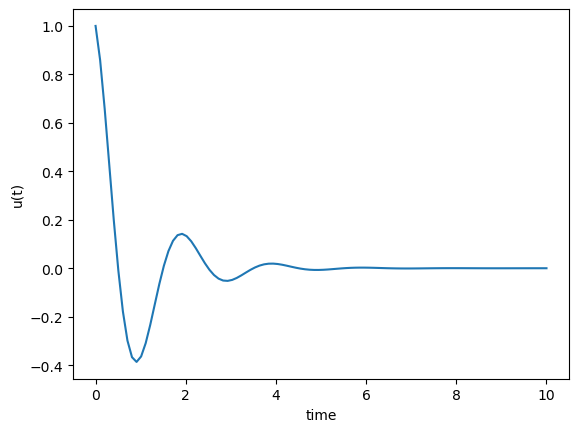

In [3]:
#Initial condition
x0 = np.zeros(n)

inp=2
#Input - % For now, let's consider a sinusoidal-decay imput
if inp==1:
    u = lambda t: np.cos(t)
else:
    u = lambda t: np.exp(-t) * np.cos(np.pi * t)

    
#Setup the simulation conditions -= that is when to get snapshots    
t_start = 0
t_final = 10
n_snapshots = 100

time_ = np.linspace(t_start, t_final, n_snapshots) #note: time_ not time


u_time = np.array([u(t) for t in time_])

plt.figure()
plt.plot(time_, u_time)
plt.xlabel('time')
plt.ylabel('u(t)');

In [4]:
# Use the Linear Simulation Tool for nonliner we can use RK45.

tic = time.time()
y_sol,t_sol, x_sol = ctrl.lsim(sys, u_time, time_, X0=x0.flatten())
toc = time.time()
X = x_sol.T

print(f"Time taken to simulate the full order LTI system -> {toc-tic}\n")
print(f"xsol.shape->{np.shape(x_sol)}, ysol.shape->{np.shape(y_sol)}")


Time taken to simulate the full order LTI system -> 0.16686654090881348

xsol.shape->(100, 1000), ysol.shape->(100,)


### POD for Linear Systems
##### Compute POD basis

In [5]:
print(f"Note the rank of X ( rank(X) = {np.linalg.matrix_rank(X)}) --> so there will be {np.linalg.matrix_rank(X)} SV's")

Note the rank of X ( rank(X) = 86) --> so there will be 86 SV's


U.shape->(1000, 100), Sigma.shape->(100,), W.shape->(100, 100)


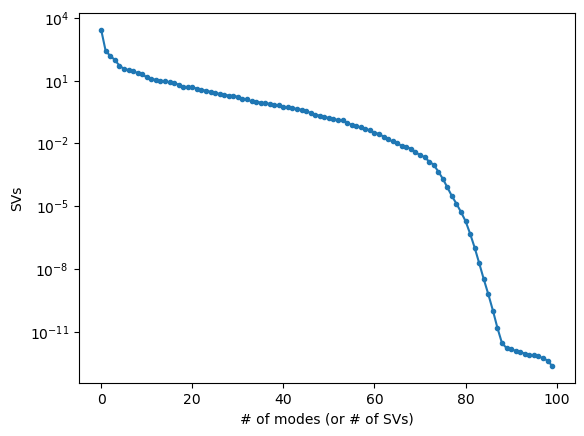

In [6]:
U, Sigma, W = svd(X, full_matrices=False)

print(f"U.shape->{np.shape(U)}, Sigma.shape->{np.shape(Sigma)}, W.shape->{np.shape(W)}")

plt.semilogy(Sigma,'.-')
plt.ylabel('SVs');
plt.xlabel('# of modes (or # of SVs)');

##### Select Truncation - look at SVD or Energy

In [7]:
r = 80
print(f"\nat r={r}, Sigma_r = {Sigma[r]} is fairly small compared to Sigma_0 = {Sigma[0]}")


at r=80, Sigma_r = 1.9707006491518706e-06 is fairly small compared to Sigma_0 = 2579.77655220266


### Perform Projection using POD-Galerkin


In [8]:
Vr = U[:, :r]
Ar = Vr.T @ A @ Vr
Br = Vr.T @ B
Cr = C @ Vr
Dr = D


# Intial Condition on reduced space
# recall x = V*xr --> xr0 = V'*x0

xr0 = Vr.T @ x0

In [9]:
tic_rom = time.time()

sys_reduced = ctrl.ss(Ar, Br, Cr, Dr)
yr_sol,tr_sol, xr_sol = ctrl.lsim(sys_reduced, u_time, time_, X0=xr0.flatten())

toc_rom = time.time()

print(f"Time taken to simulate the *reduced* order LTI system -> {toc_rom-tic_rom}\n")
print(f"xsol.shape->{np.shape(xr_sol)}, ysol.shape->{np.shape(yr_sol)}")


Time taken to simulate the *reduced* order LTI system -> 0.0

xsol.shape->(100, 80), ysol.shape->(100,)


### Reconstruct Approximate FOM States

In [10]:
# Reconstructed States
Xr_POD = Vr @ xr_sol.T

# Difference Between snapshot matrices
print(np.linalg.norm(X-Xr_POD)/np.linalg.norm(X))

0.21798639312986243


### Now, compare time plots or output comparisons

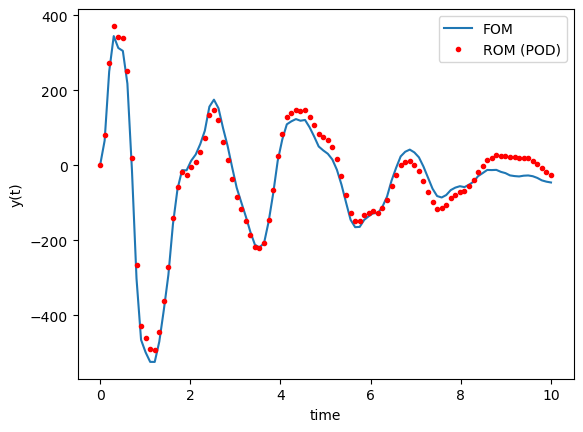

In [11]:
# Calculate outputs y = C*x+D*u

y_FOM = C @ X
y_ROM_POD = C @ Xr_POD


plt.figure()
plt.plot(t_sol, np.array(y_FOM).flatten(), tr_sol, np.array(y_ROM_POD).flatten(), 'r.')
plt.xlabel('time')
plt.ylabel('y(t)')
plt.legend(['FOM', 'ROM (POD)'])
plt.show()

### Calculate Error

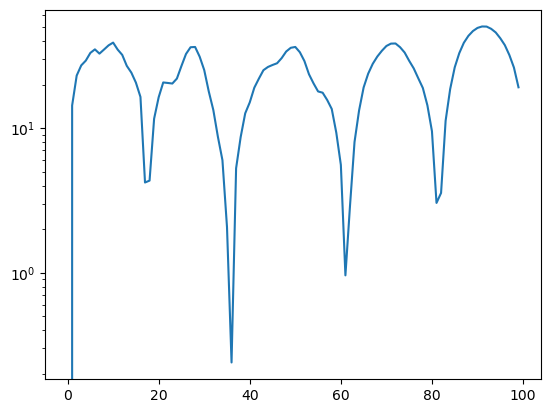

In [12]:
plt.figure
plt.semilogy(abs(np.array(y_FOM).flatten()-np.array(y_ROM_POD).flatten()))
plt.show()

In [13]:
print(f" Total_speedup = {(toc-tic)/(toc_rom-tic_rom)}")

ZeroDivisionError: float division by zero